In [97]:
import numpy as np
from scipy.interpolate import interp1d, interp2d
import matplotlib.pyplot as plt
import numpy.linalg as lin
import matplotlib.gridspec as gridspec
from random import choice
import warnings

import sys
sys.path.append("..")

from PDEs.models import *

import pypesto
import pypesto
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.visualize as visualize
import pypesto.profile as profile


In [81]:
rad_red_exp, rad_yellow_exp, rad_green_exp, rad_dark_exp, rspan_exp = np.load('../Data/data_4species_Heinrich.npy',allow_pickle = True)
rad_red = rad_red_exp + rad_dark_exp
rad_green = rad_green_exp + rad_yellow_exp
print(rad_red.shape)

N = 100 # mesh size for model
rmax = rspan_exp[-1]
dr = rmax/N

delta_t = 2760/60/49 # experimental dt
init = 10
tmax = delta_t*(49-init)
texp = np.linspace(0,tmax,len(rad_red))

dt_exp = texp[1] - texp[0]

dr_exp = rspan_exp[1] - rspan_exp[0]
rspan = np.linspace(0,rmax,N+1)

tmax = texp[-1]
dt = dt_exp/1

tspan = np.arange(0,tmax + dt,dt)

tindex = [5,15,25,35] # for model vs data comparison
print([tspan[i] + 10 for i in tindex])

f1 = interp1d(rspan_exp,rad_red[0])
r0 = f1(rspan)

f2 = interp1d(rspan_exp,rad_green[0])
g0 = f2(rspan)

solver_function = lambda Dr,kr,kg,K,K2: cell_cycle_model_radial2d_linear_diffusion(rmax,N,dt,r0,g0,tmax,Dr,kr,kg,K,K2)
solver = solver_function(1e-3, 0.3,.1,3000,5000)

(38, 40)
[14.947600661886376, 24.84280198565913, 34.73800330943188, 44.633204633204635]


In [82]:

def dist(red,green): # Distance between model and data: L2 distance in polar coordinates
    
    d1 = 0
    d2 = 0
    k = 0
    for i in tindex:
        rmodel = interp1d(rspan,red[i])(rspan_exp)
        gmodel = interp1d(rspan,green[i])(rspan_exp)
        k += len(rmodel)
        d1 += np.sum((rmodel-rad_red[i])**2*rspan_exp)*2*np.pi
        d2 += np.sum((gmodel-rad_green[i])**2*rspan_exp)*2*np.pi
    return d1,d2,k

    
def objective_fun(x): # objective function to be optimised
    
    Dr,kr,kg = 10**np.array([x[0],x[1],x[2]]) # log scale (could be changed)
    K,K2,sigma1,sigma2 = x[3],x[4],x[5],x[6]
    solver = solver_function(Dr,kr,kg,K,K2)
    red,green = solver.solve()
    d1,d2,k = dist(red,green)
    return 2*np.log(sigma1)*k + 2*np.log(sigma2)*k + d1/sigma1**2 + d2/sigma2**2


In [83]:
# Set pyPESTO problem

lb = [-4,-4,-4,3000,1000,1,1]
ub = [-2,1,1,10000,20000,1200,1000]


objective = pypesto.Objective(fun=objective_fun)
problem = pypesto.Problem(objective=objective,  # objective function
                              lb=lb,  # lower bounds
                              ub=ub,  # upper bounds
                              x_names=['Dr','kr','kg','K','K2','sigma1','sigma2'],
                             x_scales = ['log10','log10','log10','lin','lin','lin','lin'])

In [84]:
xinit = np.array([-3,-1,-1,6000,10000,100,100])
sampler = sample.AdaptiveMetropolisSampler()
resultMCMC = sample.sample(
    problem, n_samples=40000, sampler=sampler, filename=None, 
    x0 = xinit
)

100%|███████████████████████████████████| 40000/40000 [1:17:19<00:00,  8.62it/s]
Elapsed time: 4651.210806000001


/opt/anaconda3/lib/python3.9/site-packages/pypesto/visualize/sampling.py:1271: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  warnings.warn(


array([[<AxesSubplot:xlabel='iteration index', ylabel='Dr'>,
        <AxesSubplot:xlabel='iteration index', ylabel='kr'>,
        <AxesSubplot:xlabel='iteration index', ylabel='kg'>],
       [<AxesSubplot:xlabel='iteration index', ylabel='K'>,
        <AxesSubplot:xlabel='iteration index', ylabel='K2'>,
        <AxesSubplot:xlabel='iteration index', ylabel='sigma1'>],
       [<AxesSubplot:xlabel='iteration index', ylabel='sigma2'>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

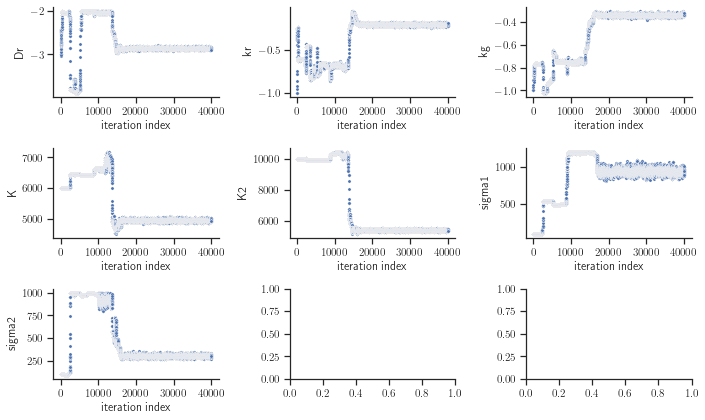

In [85]:
ax = visualize.sampling_parameter_traces(
    resultMCMC, use_problem_bounds=False, size=(10, 6)
)
ax

/opt/anaconda3/lib/python3.9/site-packages/pypesto/visualize/sampling.py:1271: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  warnings.warn(


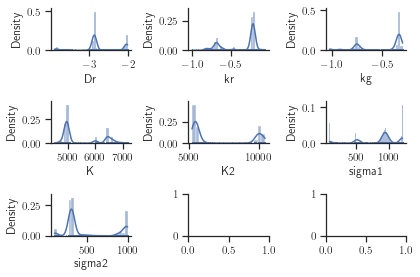

In [86]:
ax = visualize.sampling_1d_marginals(resultMCMC)

In [87]:
traces = resultMCMC.sample_result['trace_x'][0]
np.mean(traces[:], axis = 0)
chains = np.array([10**traces[:,0], 10**traces[:,1], 10**traces[:,2], traces[:,3], traces[:,4], traces[:,5],traces[:,6]])
#np.save('../Data/chains_Heinrich_new.npy') to save MCMC chains
init = 20000
conc_chain = chains[:,init:]
lims = np.array([[np.min(conc_chain[i]) - .12*(np.max(conc_chain[i]) - np.min(conc_chain[i])),np.max(conc_chain[i]) +  .12*(np.max(conc_chain[i]) - np.min(conc_chain[i]))] for i in range(7)])

In [88]:
D,kr,kg,K1,K2 = np.mean(conc_chain,axis = 1)[:-2]
print(D*1e6,kr,kg,K1,K2)
solver = solver_function(D,kr,kg,K1,K2)
red,green = solver.solve()

1396.883357929248 0.6167828789153617 0.4606852690410906 4959.445573832257 5427.042099406403


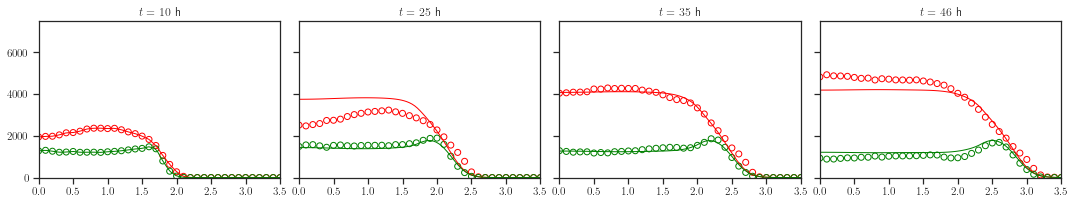

In [99]:
fig,ax = plt.subplots(1,4,figsize = (15,3))

indexes_plot = [16,26,-1]

for i in range(4):
    
    if i > 0:
        ax[i].set_yticklabels([])
    ax[i].set_ylim(0,7500)
    ax[i].set_xlim(0,3.5)
    if i == 0:
        ii = 0
    else:
        ii = indexes_plot[i-1]
    ax[i].set_title('$t = ' + str(int(tspan[ii])+10) + '$ h')
    ax[i].scatter(rspan_exp,rad_red[ii], edgecolor = 'red', color = 'none')
    ax[i].scatter(rspan_exp,rad_green[ii], edgecolor = 'green', color = 'none')
    #ax[i].scatter(rspan_exp,rad_red[ii] + rad_green[ii], edgecolor = 'black', color = 'none')
    
    rmodel = interp1d(rspan,red[ii])(rspan_exp)
    gmodel = interp1d(rspan,green[ii])(rspan_exp)
    
    
        
    ax[i].plot(rspan,red[ii], color = 'red',lw = 1)
    ax[i].plot(rspan,green[ii], color = 'green',lw = 1)
    #ax[i].plot(rspan,green[ii]+red[ii], color = 'black',lw = 1)
plt.tight_layout()
#plt.savefig('fit_linear.pdf')
plt.show()

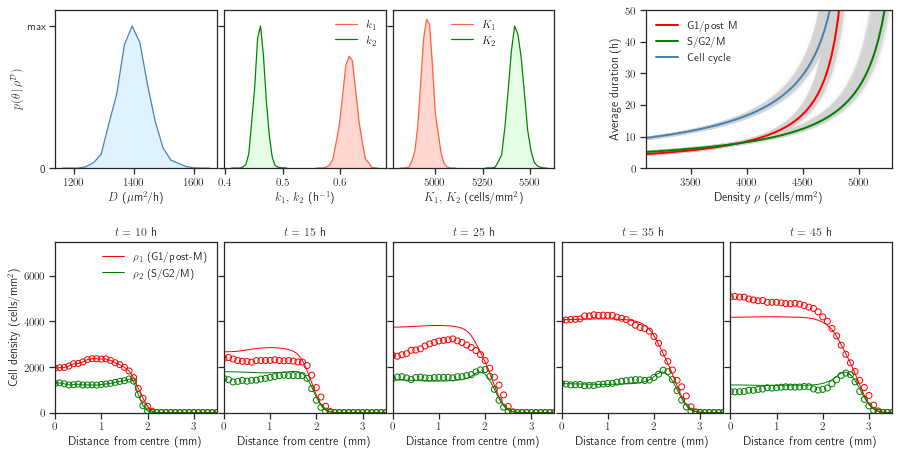

In [100]:
fig = plt.figure(figsize = (15,7.4))
spec = gridspec.GridSpec(ncols=20, nrows=3, figure=fig,height_ratios=[12,2,13])
ax = [fig.add_subplot(spec[0, 4*i:4*(i+1)]) for i in range(3)]
bx = [fig.add_subplot(spec[-1,  4*i:4*(i+1)]) for i in range(5)]
cx = fig.add_subplot(spec[0, 14:])

ax[0].set_ylabel('$p(\\theta\,|\,\\rho^\mathcal{D})$')


ax[1].set_xlabel('$k_1,\, k_2$ (h$^{-1}$)')
ax[2].set_xlabel('$K_1,\, K_2$ (cells/mm$^2$)')

ax[0].set_xlabel('$D$ ($\mu$m$^2$/h)')

densities = []

for i in range(5):
    if i == 2:
        ii = 1
        clr = 'green'
        clrfill = 'palegreen'
        lb = '$k_2$'
    elif i == 3:
        ii = 2
        clr = 'tomato'
        clrfill = 'tomato'
        lb = '$K_1$'
    elif i == 4:
        ii = 2
        clr = 'green'
        clrfill = 'palegreen'
        lb = '$K_2$'
    elif i == 0:
        ii = 0
        clr = 'steelblue'
        clrfill = 'lightskyblue'
        lb = '$D$'
    else:
        ii = i
        clr = 'tomato'
        clrfill = 'tomato'
        lb = '$k_1$'
    dens,bins = np.histogram(conc_chain[i],bins = 20, range = (lims[i][0],lims[i][1]))
    densities.append(dens)
 
    ax[ii].set_yticks([0,1*np.max(dens)])
    if i == 0:
        ax[ii].set_yticklabels([0,'max'])
    else:
        ax[ii].set_yticklabels([])

    ax[ii].set_ylim(0,np.max(dens)*1.11)

    ax[ii].plot(.5*(bins[1:] + bins[:-1])*(1 + (i==0)*1e6),dens, color = clr,lw = 1.2,label = lb)

    ax[ii].fill_between(.5*(bins[1:] + bins[:-1])*(1 + (i==0)*1e6),dens, color = clrfill,alpha = .25)
    

indexes_plot = [6,16,26,36]
bx[0].set_ylabel('Cell density (cells/mm$^2$)')

for i in range(5):
    bx[i].set_xlabel('Distance from centre (mm)')
    
    if i > 0:
        bx[i].set_yticklabels([])
    bx[i].set_ylim(0,7500)
    bx[i].set_xlim(0,3.5)
    if i == 0:
        ii = 0
    else:
        ii = indexes_plot[i-1]
    bx[i].set_title('$t = ' + str(int(tspan[ii])+10) + '$ h')
    bx[i].scatter(rspan_exp,rad_red[ii], edgecolor = 'red', color = 'none')
    bx[i].scatter(rspan_exp,rad_green[ii], edgecolor = 'green', color = 'none')
    
    rmodel = interp1d(rspan,red[ii])(rspan_exp)
    gmodel = interp1d(rspan,green[ii])(rspan_exp)
    
   
        
    bx[i].plot(rspan,red[ii], color = 'red',lw = 1,label = '$\\rho_1$ (G1/post-M)')
    bx[i].plot(rspan,green[ii], color = 'green',lw = 1,label = '$\\rho_2$ (S/G2/M)')

    
rhomax = 5300
warnings.filterwarnings("ignore")
rhospan = np.linspace(500,rhomax,160)
r1 = kr*(1-rhospan/K1)*(rhospan < K1)
r2 = kg*(1-rhospan/K2)*(rhospan < K2)
a = 0.08
nmax = 1000
nmax = 1000
indexes = [i for i in range(len(conc_chain[0]))]
samples = [choice(indexes) for i in range(nmax)]
for i in range(nmax):
    Dr,kr,kg,K1,K2 = conc_chain[:,samples[i]][:-2]
    r1 = kr*(1-rhospan/K1)*(rhospan < K1)
    r2 = kg*(1-rhospan/K2)*(rhospan < K2)
    cx.plot(rhospan, 1/r1, color = 'lightgray',alpha = a,lw = 1.5)
    cx.plot(rhospan, 1/r2,color = 'lightgray',alpha = a, lw = 1.5)
    cx.plot(rhospan, 1/r1 + 1/r2,color = 'lightgray',alpha = a,lw = 1.5)
cx.plot(rhospan, 1/r1, color = 'red',lw = 2,label = 'G1/post M')
cx.plot(rhospan, 1/r2, color = 'green',lw = 2,label = 'S/G2/M')
cx.plot(rhospan, 1/r1 + 1/r2,color = 'steelblue',lw = 2,label = 'Cell cycle')
cx.set_ylim(0,50)
cx.set_xlim(3100,rhomax)
cx.set_xlabel('Density $\\rho$ (cells/mm$^2$)')
cx.set_ylabel('Average duration (h)')
cx.legend(frameon = False, loc = 2)

ax[1].legend(frameon = False)
ax[2].legend(frameon = False)
bx[0].legend(frameon = False)
#plt.tight_layout()
#plt.savefig('Figure2.pdf')
plt.show()